Pour qu'il n'ai pas de problème lors des importations

In [1]:
# import sys
# sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

# Importation

In [2]:
from fastmri.data import transforms as T
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable

from utils.vcr import virtual_coil_reconstruction
from utils.data_transform import load_and_transform

from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.varnet import VarNet 


# Download & Transform

In [3]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"

# Renvoie un Tensor Pytorch 
kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))

# Renvoie une image Single Coil
image = virtual_coil_reconstruction(images_multicoil)

# Coil = 1 
image = image.unsqueeze(1)

# Kspace of the new image
kspace = torch.fft.fft2(image)

print(kspace_multicoil.shape)
print(images_multicoil.shape)
print(image.shape)
print(kspace.shape)

torch.Size([16, 16, 640, 320])
torch.Size([16, 16, 640, 320])
torch.Size([16, 1, 640, 320])
torch.Size([16, 1, 640, 320])


Show all the batch

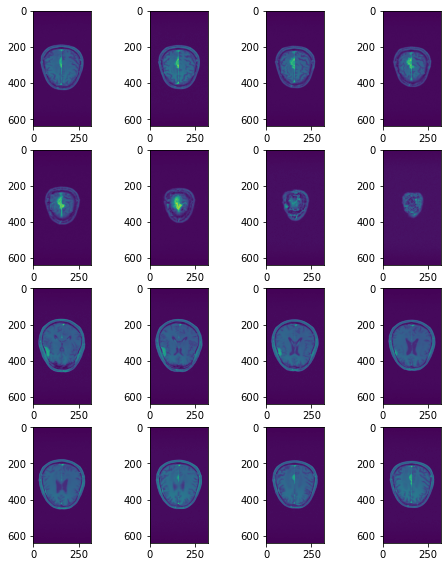

In [4]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show image (abs(image))
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.abs(image[i, 0, :,:]))

# # Show image's phase (angle(image))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.angle(image[i, 0, :,:]))

# # Show kspace (abs(kspace))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(kspace[i,0, :,:]))


# Mask application

In [5]:
#  Parametres
mask_type = "random"
center_fractions = [0.08]
accelerations = [4]

# Function de Mask
mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

# Reajustement shape pour bien avoir un mask en fonction de l'Ordonnée car dim = 2
kspace = kspace.unsqueeze(-1)

# Application
masked_kspace_list, mask_list = [], []
for batch in range (kspace.shape[0]) :
    mask, _ = mask_func(kspace.shape)
    masked_kspace = kspace[batch] * mask

    masked_kspace_list.append(masked_kspace)
    mask_list.append(mask)

masked_kspace = torch.cat(masked_kspace_list)
mask = torch.cat(mask_list)

# Pour l'entrainement
target = image.abs().squeeze(1)

print("kspace : ",kspace.shape)
print("all masks: ",mask.shape)
print("input: ", masked_kspace.shape)
print("target : ", target.shape)

kspace :  torch.Size([16, 1, 640, 320, 1])
all masks:  torch.Size([16, 1, 1, 320, 1])
input:  torch.Size([16, 1, 640, 320, 1])
target :  torch.Size([16, 640, 320])


Show all the batch

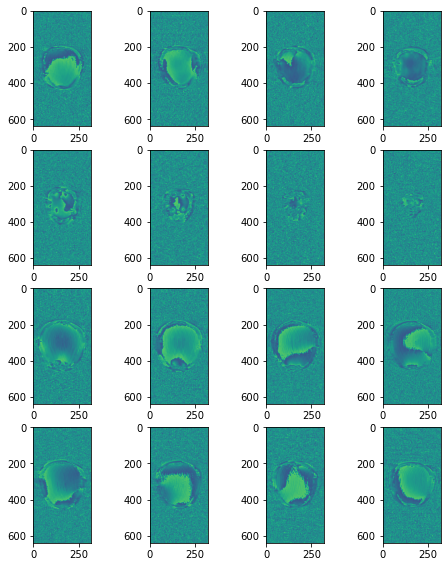

In [6]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show the input : it's a kspace 
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(masked_kspace[i, 0, :,:]))

# # Show the image of the input
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(torch.fft.ifftn(masked_kspace[i, 0, :,:])))

# # Show the phase of the image of the input
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.angle(torch.fft.ifftn(masked_kspace[i, 0, :,:])))


Reajustement shape

In [7]:
# zero_filled's shape
masked_kspace = masked_kspace.squeeze(-1)
    # Création d'une nouvelle dimension pour dissocier la partie réel et imaginaire des complex
shape_new = image.shape + (2,)
masked_kspace_new = torch.zeros(shape_new)
masked_kspace_new[..., 0] = masked_kspace.real
masked_kspace_new[..., 1] = masked_kspace.imag 

print("input: ", masked_kspace_new.shape)
print("target : ", target.shape)

input:  torch.Size([16, 1, 640, 320, 2])
target :  torch.Size([16, 640, 320])


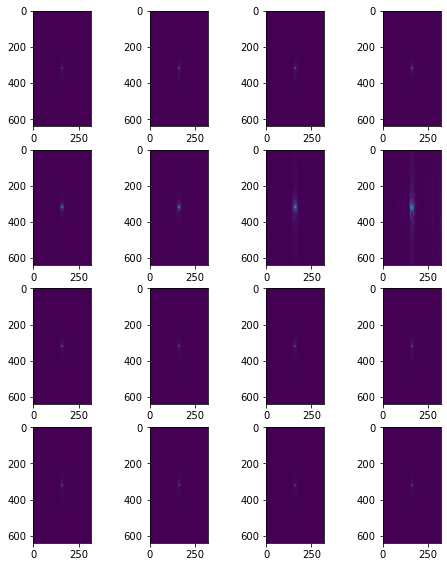

In [8]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show zero-filled'kspace 
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.abs(1j*masked_kspace_new[i,0,:,:,1]+masked_kspace_new[i,0,:,:,0]))

# Show input
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     input_image = torch.fft.ifftn(masked_kspace_new[i])
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(1j*input_image[0,:,:,1]+input_image[0,:,:,0]))

# # Show input's phase
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     input_image = torch.fft.ifftn(masked_kspace_new[i])
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.angle(1j*input_image[0,:,:,1]+input_image[0,:,:,0]))


# Varnet model

In [9]:
# Parametre
chans = 32
center_fractions = [0.08]
accelerations = [4]
mask_center = True
lr = 0.0001

# Model
varnet = VarNet(
    num_cascades=2,
    sens_chans=4,
    sens_pools=2,
    chans=chans,
    pools=2,
    mask_center=mask_center,
)

# Loss
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(varnet.parameters(), lr=lr)
loss_list = []

# Train
num_epochs = 50
for epoch in range(num_epochs):

    optimizer.zero_grad()

    outputs = varnet(masked_kspace_new, mask.byte())
    
    loss = criterion(outputs, target)
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}]')

torch.save(varnet.state_dict(), 'fastmri_varnet_model.pth')

/home/lo276838/.local/lib/python3.10/site-packages/fastmri/models/varnet.py:318: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:519.)
  soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.dc_weight


Epoch [1/50]
Epoch [2/50]
Epoch [3/50]
Epoch [4/50]
Epoch [5/50]
Epoch [6/50]
Epoch [7/50]
Epoch [8/50]
Epoch [9/50]
Epoch [10/50]
Epoch [11/50]
Epoch [12/50]
Epoch [13/50]
Epoch [14/50]
Epoch [15/50]
Epoch [16/50]
Epoch [17/50]
Epoch [18/50]
Epoch [19/50]
Epoch [20/50]
Epoch [21/50]
Epoch [22/50]
Epoch [23/50]
Epoch [24/50]
Epoch [25/50]
Epoch [26/50]
Epoch [27/50]
Epoch [28/50]
Epoch [29/50]
Epoch [30/50]
Epoch [31/50]
Epoch [32/50]
Epoch [33/50]
Epoch [34/50]
Epoch [35/50]
Epoch [36/50]
Epoch [37/50]
Epoch [38/50]
Epoch [39/50]
Epoch [40/50]
Epoch [41/50]
Epoch [42/50]
Epoch [43/50]
Epoch [44/50]
Epoch [45/50]
Epoch [46/50]
Epoch [47/50]
Epoch [48/50]
Epoch [49/50]
Epoch [50/50]


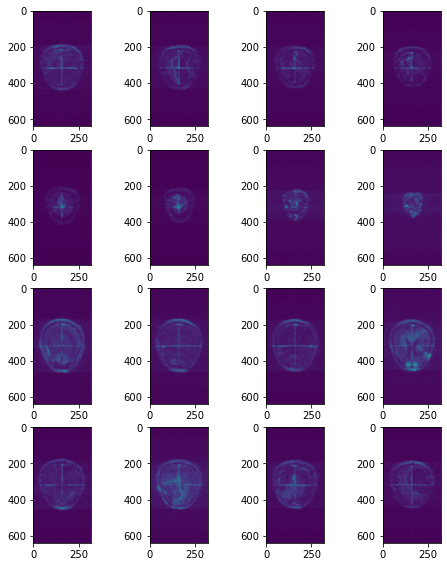

In [10]:
# plt.figure(figsize=(8,20))
# for i in range(outputs.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(torch.fft.fftshift(outputs[i]).detach().numpy())

plt.figure(figsize=(8,20))
for i in range(outputs.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(torch.fft.fftshift(outputs[i]).detach().numpy())


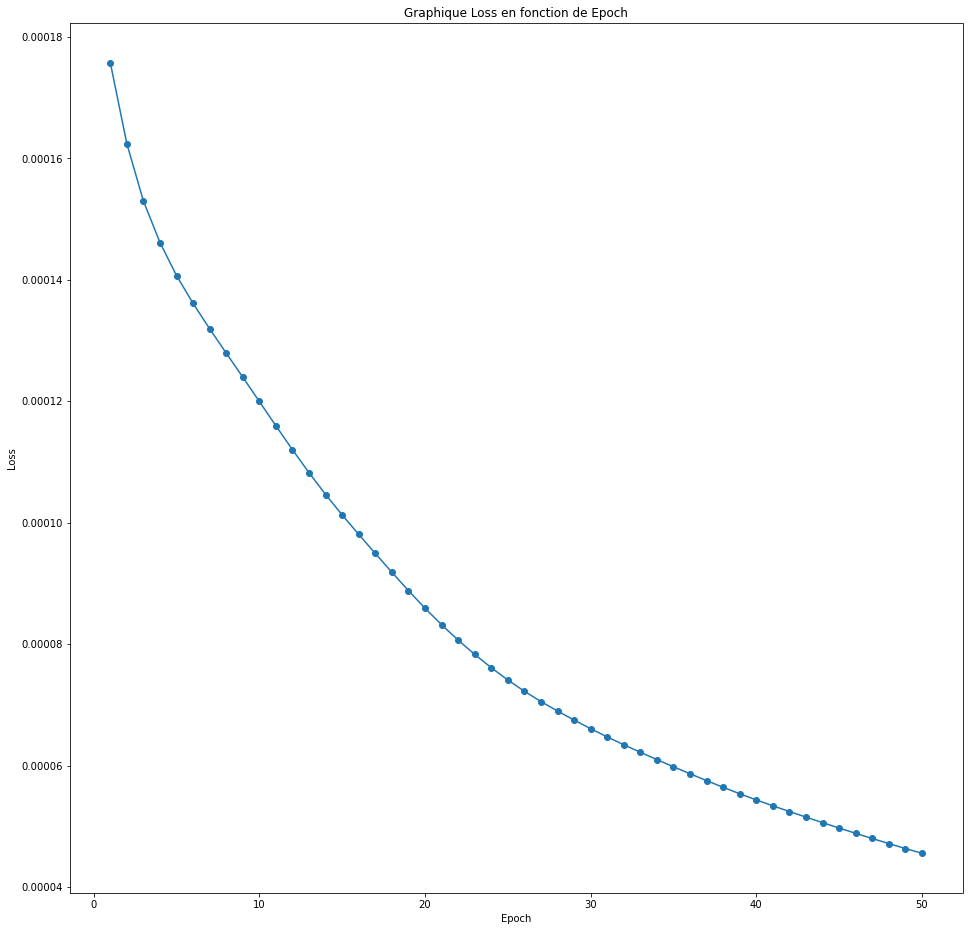

In [11]:
indices = list(range(1, len(loss_list) + 1))

plt.plot(indices, loss_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graphique Loss en fonction de Epoch')
plt.show()


# Test the model 

In [12]:
model = VarNet(
    num_cascades=2,
    sens_chans=4,
    sens_pools=2,
    chans=chans,
    pools=2,
    mask_center=mask_center,
)
model.load_state_dict(torch.load('fastmri_varnet_model.pth'))

file_path_T = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
kspace_multicoil_T = load_and_transform(file_path_T)
images_multicoil_T = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil_T))
image_T = virtual_coil_reconstruction(images_multicoil_T)
image_T = image_T.unsqueeze(1)
kspace_T = torch.fft.fft2(image_T)


mask_func_T = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
kspace_T = kspace_T.unsqueeze(-1)

masked_kspace_list, mask_list = [], []
for batch in range (kspace_T.shape[0]) :
    mask_T, _ = mask_func_T(kspace_T.shape)
    masked_kspace_T = kspace_T[batch] * mask_T

    masked_kspace_list.append(masked_kspace_T)
    mask_list.append(mask_T)

masked_kspace_T = torch.cat(masked_kspace_list)
mask_T = torch.cat(mask_list)


# zero_filled's shape
masked_kspace_T = masked_kspace_T.squeeze(-1)
shape_new = image_T.shape + (2,)
input_T = torch.zeros(shape_new)
input_T[..., 0] = masked_kspace_T.real
input_T[..., 1] = masked_kspace_T.imag 

test_image = input_T

model.eval()
with torch.no_grad():
    predicted_images = model(test_image, mask_T.byte())
model.train()


VarNet(
  (sens_net): SensitivityModel(
    (norm_unet): NormUnet(
      (unet): Unet(
        (down_sample_layers): ModuleList(
          (0): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (2): LeakyReLU(negative_slope=0.2, inplace=True)
              (3): Dropout2d(p=0.0, inplace=False)
              (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (5): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (6): LeakyReLU(negative_slope=0.2, inplace=True)
              (7): Dropout2d(p=0.0, inplace=False)
            )
          )
          (1): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [13]:
print(test_image.shape)
print(predicted_images.shape)
print(predicted_images.dtype)

torch.Size([16, 1, 640, 320, 2])
torch.Size([16, 640, 320])
torch.float32


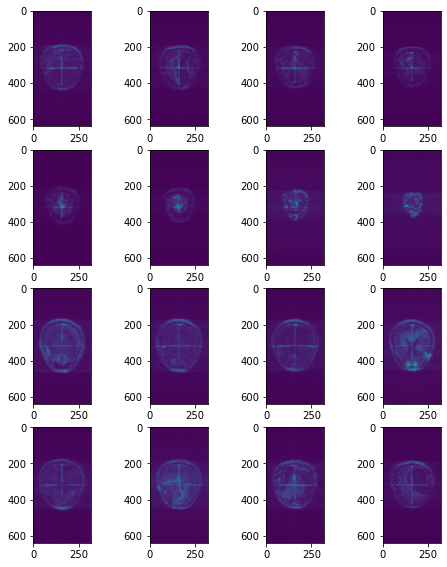

In [14]:
plt.figure(figsize=(8,20))
for i in range(predicted_images.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(torch.fft.fftshift(predicted_images[i]).detach().numpy())


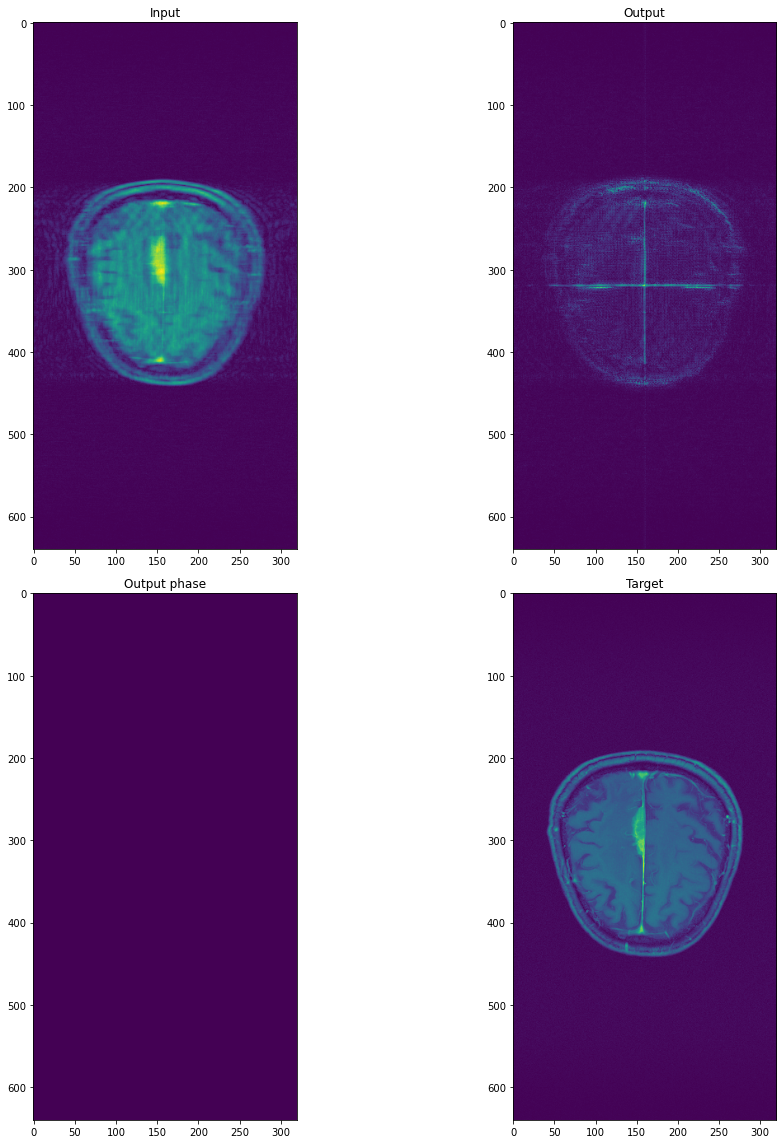

In [15]:
plt.subplot(2,2,1)
plt.imshow(np.abs(torch.fft.ifftn(1j*test_image[0, 0,:,:,1])+torch.fft.ifftn(test_image[0, 0,:,:,0])))
plt.title("Input")

plt.subplot(2,2,2)
plt.imshow(torch.fft.fftshift(predicted_images[0]))
plt.title("Output")

plt.subplot(2,2,3)
plt.imshow(np.angle(torch.fft.fftshift(predicted_images[0])))
plt.title("Output phase")

plt.subplot(2,2,4)
plt.imshow(np.abs(image[0, 0]))
plt.title("Target")

plt.tight_layout()
plt.show()